# Method 2 for time stepping

### remind: C-H equation

$\frac{\triangledown c}{\delta t}=\triangledown M. \triangledown \mu$

where $ \triangledown\mu =\triangledown[ \frac{\delta f}{\delta c}-\kappa \triangledown^{2}c] $

This proposed adaptive method of time-stepping uses a criterion related to a residual of the discrete nergy law.
The method is as follows:       
- step 1: compute $c^{n+1}$ and obtain:
  $  RE^{ n+1}=\frac{\epsilon(\phi^{n+1})-\epsilon(\phi^{n})}{\triangle t^{n}}+\int_{\omega}^{} |\triangledown\mu^{n+\frac{1}{2}}|^{2} dV$
        

$t^{n+\frac{1}{2}} =(t^{n}+t^{n+1})/2$

 - step 2: if $RE^{ n+1}> resmax$ take $\triangle t^{n+1} = \triangle t^{n}/\theta $ and go to step 1
 - step 3: if $RE^{ n+1}< resmin$ take $\triangle t^{n+1} =\theta \triangle t^{n}$

 Where resmax and resmin are abtained by trail and error.
 
  $\theta$  >1 




# Numerical implementation

The term   $\int_{\omega}^{} |\triangledown\mu^{n+\frac{1}{2}}|^{2} dV$ is computed as follows in Fourier space:
- if istep > 1 :

    $\triangledown\mu =\triangledown[ \frac{\delta f}{\delta c}-\kappa \triangledown^{2}c] $
    
    FFT => ${\triangledown\mu} =(jk).[ \{\frac{\delta f}{\delta c} \} _k +\kappa. k^2.\{ c \}_k ]$

    $ \triangledown\mu^{n+\frac{1}{2}}= (\triangledown\mu^{n-1}+\triangledown\mu^{n})/2$


# Import

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
import math
import pyvista as pv
import pyfftw          # use for fast fourier transform
from scipy.fft import fft, ifft
from numba import jit  # use to speed up 
import scipy.stats as st
import time
from scipy.sparse import csgraph

# Functions

In [47]:
def free_energ(c):
    A=1.0
    dfdc =A*(2.0*c*(1-c)**2 -2.0*c**2 *(1.0-c))
    return dfdc


#--------------------------------------------------------------------------------------------------

def fft_(a):
    """
    return a fft object from pyfftw library that will be use to compute fft
    """
    fft_object=pyfftw.builders.fftn(a,axes=(0,1,2), threads=12)
    return fft_object()
#--------------------------------------------------------------------------------------------------

def ifft_(a):
    """
    return a inverse fft object from pyfftw library that will be use to compute inverse fft
    """
    ifft_object=pyfftw.builders.ifftn(a,axes=(0,1,2), threads=12)
    return ifft_object()
#--------------------------------------------------------------------------------------------------
#@jit(nopython=True)
def micro_ch_pre(Nx,Ny,Nz,c0):
    c=np.zeros((Nx,Ny,Nz))
    noise=0.02
    for i_x in range(Nx):
        for i_y in range(Ny):
            for i_z in range(Nz):
                c[i_x,i_y,i_z] =c0 + noise*(0.5-np.random.rand())                 
    return c

# Compute energy evolution
def calculate_energ(Nx,Ny,Nz,c,grad_coef):
    energ =0.0
    # ------------Nx------------------------------
    for i in range (Nx-1): 
        ip = i + 1
        #--------------Ny-------------------------
        if (Ny>1):
            for j in range (Ny-1):
                jp = j + 1
                # ----------Nz--------------------
                if (Nz>1): # 3D
                    for l in range (Nz-1):
                        lp = l + 1 
                        energ += c[i,j,l]**2  *(1.0-c[i,j,l])**2  +  0.5*grad_coef*((c[ip,j,l]-c[i,j,l])**2 \
                            +(c[i,jp,l]-c[i,j,l])**2     + (c[i,j,lp]-c[i,j,l])**2)
                else: # (Nz==1) 2D
                        energ += c[i,j,0]**2  *(1.0-c[i,j,0])**2  +  0.5*grad_coef*((c[ip,j,0]-c[i,j,0])**2 \
                        +(c[i,jp,0]-c[i,j,0])**2) 
        else : # (Ny==1): 
            # ----------Nz--------------------
            if (Nz>1): # 2D
                 for l in range (Nz-1):
                     lp = l + 1
                     energ += c[i,0,l]**2  *(1.0-c[i,0,l])**2  +  0.5*grad_coef*((c[ip,0,l]-c[i,0,l])**2 \
                     + (c[i,0,lp]-c[i,0,l])**2)       
            else : # (Nz==1) 1D
                energ += c[i,0,0]**2  *(1.0-c[i,0,0])**2  +  0.5*grad_coef*(c[ip,0,0]-c[i,0,0])**2                         
         
    return energ


#---------------------------------------------------------------------------------------------------   
def infinite_norm(M):
    # suppose that Nz=1
    m=M.shape[0]
    n=M.shape[1]
    array_row_sum=[]
    for i in range(m):
        row_sum=0
        for j in range(n):
            row_sum+=np.abs(M[i,j,0])
        array_row_sum.append(row_sum)
    inf_norm=np.max(array_row_sum)
    return inf_norm
# compute 2D laplacian 
def laplacian_2D(c,i,j,l,dx,dy,dz):
    ip=i+1
    im=i-1
    jp=j+1
    jm=j-1
    if (im==-1):
        im=Nx-1
    if (ip==Nx):
        ip=0
    if (jm==-1):
        jm=Ny-1
    if (jp==Ny):
        jp=0
    hne=c[ip,j,0]
    hnw=c[im,j,0]
    hns=c[i,jm,0]
    hnn=c[i,jp,0]
    hnc=c[i,j,0]
    laplacian=(hnw+hne+hns+hnn-4*hnc)/(dx*dy) # uniform mesh
    return laplacian

# compute gradient
def gradient(c,i,j,l,dx,dy,dz):   
    Nx=c.shape[0]
    Ny=c.shape[1]
    Nz=c.shape[2]
    im=i-1
    jm=j-1
    lm=l-1
    if (im==-1):
        im=Nx-1
    if (jm==-1):
        jm=Ny-1
    if (lm==-1):
        lm=Nz-1

    hw=c[im,j,l]
    hs=c[i,jm,l]
    hz=c[i,j,lm]
    hc=c[i,j,l]

    grad_mu_x=(hc-hw)/dx
    grad_mu_y=(hc-hs)/dx
    grad_mu_z=(hc-hz)/dx

    return grad_mu_x,grad_mu_y,grad_mu_z

# remind

$\frac{\triangledown c}{\delta t}=\triangledown M. \triangledown \mu$

where $ \triangledown\mu =\triangledown[ \frac{\delta f}{\delta c}-\kappa \triangledown^{2}c] $

In [48]:
# compute residual at each time step (if istep >1), using Fourier space
def compute_residual_fft(array_energy,dtime, array_df_dc_k,array_ck,istep,k, kappa):
    grad_mu_minus= (1j*k)* (array_df_dc_k[istep-1]+kappa*(k**2)*array_ck[istep-1] )  
    grad_mu_plus=  (1j*k)* (array_df_dc_k[istep]+kappa*(k**2)*array_ck[istep] )
    grad_mu_mean= (grad_mu_minus+grad_mu_plus)/2
    grad_mu_mean=np.real(ifft_(grad_mu_mean))
    # residual
    A=(array_energy[istep]-array_energy[istep-1])/dtime
    B=(grad_mu_mean**2).sum()
    RES=A+B
    return RES,A,B

# compute residual at each time step (if istep >1), using Finite Difference
def compute_residual_FD(array_energy,dtime, array_df_dc,array_c,istep, kappa):
    dx=1
    dy=1
    dz=1
    grad_mu_minus=gradient_1D(array_df_dc[istep-1]- laplacian_1D(array_c[istep-1],dx,dy,dz),dx,dy,dz )                  
    #grad_mu_minus=array_df_dc[istep-1] - kappa* (np.gradient(array_c[istep-1].flatten(), dx))**2
    grad_mu_plus=gradient_1D(array_df_dc[istep] - laplacian_1D(array_c[istep],dx,dy,dz),dx,dy,dz) 
    #grad_mu_plus=array_df_dc[istep] - kappa*  (np.gradient(array_c[istep].flatten(), dx))**2
    grad_mu_mean= (grad_mu_minus+grad_mu_plus)/2

    # residual
    A=(array_energy[istep]-array_energy[istep-1])/dtime
    B=(grad_mu_mean[0]**2).sum()
    RES=A+B
    return RES,A,B 
# -------------------------------------------------------------------
def compute_residual_fd(dtime, array_energy,array_dfdc,array_c, kappa,istep):
    sum_L2_square=0
    grad_mu=np.zeros((3,1))
    dfdc=array_dfdc[istep]
    dfdc_1=array_dfdc[istep-1]
    c=array_c[istep]
    c_1=array_c[istep-1]
    Nx=c.shape[0]
    Ny=c.shape[1]
    Nz=c.shape[2]
    mu=np.zeros((Nx,Ny,Nz))
    mu_p=np.zeros((Nx,Ny,Nz))
    mu_m=np.zeros((Nx,Ny,Nz))
    # compute \mu
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                mu_p[i,j,l]=dfdc[i,j,l]-kappa*laplacian_2D(c,i,j,l,dx_s,dy_s,dz_s)
                mu_m[i,j,l]=dfdc_1[i,j,l]-kappa*laplacian_2D(c_1,i,j,l,dx_s,dy_s,dz_s)
    mu=(mu_p+ mu_m)/2            

    # compute Nabla(\mu) at each point grid and the associated L2 norm **2
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                grad_mu_x,grad_mu_y,grad_mu_z=gradient(mu,i,j,l,dx_s,dy_s,dz_s)
                grad_mu=np.array([grad_mu_x,grad_mu_y,grad_mu_z])
                sum_L2_square+=np.linalg.norm(grad_mu, ord=2)**2
    # A: energy derivative
    A=(array_energy[istep]-array_energy[istep-1])/dtime
    B=sum_L2_square
    RES=A+B

    return RES, A, B


In [49]:
@jit(nopython=True)
def prepar_fft(Nx,dx,Ny,dy,Nz,dz,opt): 
    """
    Compute spatial frequence term and derivative
    """
    # variable initialisation
    lin_x=np.zeros(Nx)
    lin_y=np.zeros(Ny)
    lin_z=np.zeros(Nz)
        
    k=np.zeros((3,Nx,Ny,Nz))
    k2=np.zeros((Nx,Ny,Nz))
    k4=np.zeros((Nx,Ny,Nz))
        
    """
    # Method 1 to compute k  (3D)
    if (Nx % 2) == 1 : # = number odd if remainers is one
        lin_x[:int((Nx-1)/2.0+1)]=np.arange(0, int((Nx-1)/2.0+1), 1)*2*np.pi/(Nx*dx)
        lin_x[int((Nx-1)/2.0+1):]=np.arange(int(-(Nx+1)/2.0 +1), 0, 1)*2*np.pi/(Nx*dx)
    if (Ny % 2) == 1 :
        lin_y[:int((Ny-1)/2.0+1)]=np.arange(0, int((Ny-1)/2.0+1), 1)*2*np.pi/(Ny*dy)
        lin_y[int((Ny-1)/2.0+1):]=np.arange(int(-(Ny+1)/2.0 +1), 0, 1)*2*np.pi/(Ny*dy)
    if (Nz % 2) == 1 :
        lin_z[:int((Nz-1)/2.0+1)]=np.arange(0, int((Nz-1)/2.0+1), 1)*2*np.pi/(Nz*dz)
        lin_z[int((Nz-1)/2.0+1):]=np.arange(int(-(Nz+1)/2.0 +1), 0, 1)*2*np.pi/(Nz*dz)        
    if (Nx % 2) == 0 : # = number even if remainers is zero
        lin_x[0:int(Nx/2.0)]=np.arange(0, int(Nx/2.0), 1)*2*np.pi/(Nx*dx)
        lin_x[int(Nx/2.0 + 1):]=np.arange(int(-Nx/2.0 + 1), 0, 1)*2*np.pi/(Nx*dx)
    if (Ny % 2) == 0 :
        lin_y[0:int(Ny/2.0)]=np.arange(0, int(Ny/2.0), 1)*2*np.pi/(Ny*dy)
        lin_y[int(Ny/2.0 + 1):]=np.arange(int(-Ny/2.0 + 1), 0, 1)*2*np.pi/(Ny*dy)  
    if (Nz % 2) == 0 :
        lin_z[0:int(Nz/2.0)]=np.arange(0, int(Nz/2.0), 1)*2*np.pi/(Nz*dz)
        lin_z[int(Nz/2.0 + 1):]=np.arange(int(-Nz/2.0 + 1), 0, 1)*2*np.pi/(Nz*dz)          
    # grid   
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                 k[0,i,j,l]= lin_x[i]
                 k[1,i,j,l]= lin_y[j]
                 k[2,i,j,l]= lin_z[l]
     """
    # Method 2 to compute k      
    Lx=Nx*dx
    x=np.linspace(-0.5*Lx+dx,0.5*Lx,Nx)
    
    Ly=Ny*dy
    y=np.linspace(-0.5*Ly+dy,0.5*Ly,Ny)
    
    Lz=Nz*dz
    z=np.linspace(-0.5*Lz+dz,0.5*Lz,Nz)
         
    
    xx=2*np.pi/Lx*np.concatenate((np.arange(0,Nx/2+1), np.arange(-Nx/2+1,0)),axis=0)
    yy=2*np.pi/Ly*np.concatenate((np.arange(0,Ny/2+1), np.arange(-Ny/2+1,0)),axis=0)
    zz=2*np.pi/Lz*np.concatenate((np.arange(0,Nz/2+1), np.arange(-Nz/2+1,0)),axis=0)
        
    for i in range(Nx):
        for j in range(Ny):
            for l in range(Nz):
                k[0,i,j,l]= xx[i]
                k[1,i,j,l]= yy[j]
                k[2,i,j,l]= zz[l]           
                
    k2=k[0]**2+k[1]**2+k[2]**2
  
    k4=k2**2
         
    return k,k2,k4,x,y,z

In [50]:
# plot micro
def plot_micro(c,opt,ttime):
    # 1D case
    if (opt=='1D'):
        plt.plot(c[:, :, 0])
        plt.xlabel('x')
        plt.ylabel('concentration')
        plt.title('initial concentration')

    else: 
        # 2D or 3D cases--------------------------------------------------
        import sys
        grid  = pv.UniformGrid()
        grid.spacing=np.array([dx,dx,dx])*1E9
        grid.dimensions = np.array([Nx,Ny,Nz])#+1
        grid.point_arrays[r'c'] = np.transpose(np.resize(c,[Nx,Ny,Nz])).flatten()
        

        # Set a custom position and size
        sargs = dict(fmt="%.1f", color='black') 

        p = pv.Plotter()
        pv.set_plot_theme("ParaView")
        p.set_background("white")
        p.add_mesh(grid,show_scalar_bar=False,label='title')
        p.add_scalar_bar('Concentration', color='black',label_font_size=12, width=0.1, height=0.7, position_x=1,position_y=0.16,vertical= True, interactive=False)
        if (ttime==0):
            p.add_text('Initial Microstructure ',position='upper_edge',color='black',font= 'times',font_size=12)
        else:
            p.add_text('Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) ),color='black',font= 'times',font_size=12)

        p.show_bounds(all_edges=True,font_size=24,bold=True, xlabel="X [nm]",ylabel="Y [nm]",zlabel="Z [nm]",color='black')
        #p.add_title('Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) ))
        p.camera_position = [1, 1, 1]
        if (opt=='2D'):
            if (ttime==0):
                p.show(screenshot='Initial microstructure.png',cpos="xy") # cpos="xy" in case of 2D (Nz=1)
            else:
                p.show(screenshot='Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) )+ '.png',cpos="xy") #
        elif (opt=='3D'):
            if (ttime==0):
                p.show(screenshot='Initial microstructure.png') # cpos="xy" in case of 2D (Nz=1)
            else:
                p.show(screenshot='Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime) )+ '.png') #

        p.close()

In [51]:
def plot_micro_mayavi(c,ttime):
    from mayavi import mlab
    #mlab.clf()
    X, Y, Z = np.meshgrid(x,y,z)
    values = c
    fig = mlab.figure(figure=None, fgcolor=(0, 0, 0), bgcolor=(1,1,1), engine=None, size=(500, 500))
    mlab.contour3d(values,colormap='hot')
    mlab.axes(xlabel='Z', ylabel='Y', zlabel='X')
    mlab.colorbar(title='Concentration',orientation='vertical', nb_labels=5)
    if (ttime==0):
        name ='Initial microstructure'
    else:
        name='Microstructure at dimensionless time '+str('{0:.2f}'.format(ttime))
    mlab.title(name)
    #☻mlab.text(6, -2.5, '', z=-4, width=0.14)
    mlab.orientation_axes([0,0.5,0.5 ])
    mlab.savefig(name+'.png')
    mlab.show(stop=True)

In [52]:
def micro_numba(c0,r,ox,oy,oz,Nx,Ny,Nz):
    """
    Microstructure initialization:
    inputs: the position and radius of sphere that represents the precipitate of 
    composition X0_pre for a matrix of compositon X0_mat
    outpus: value of the variable eta and X_mat for a given grid 
    """

    c   = np.zeros((Nx,Ny,Nz)) 
    x      = np.arange(Nx)*dx
    y      = np.arange(Ny)*dy
    z      = np.arange(Nz)*dz
    
    for i_x in range(Nx):
        for i_cir in range(len(r)): 
            norm=np.sqrt( (ox[i_cir]-x[i_x])**2) 

            if norm<=r[i_cir]:
                c[i_x][0][0]  =1

    return c

# Input Data

In [53]:
Nx=128 ; Ny=128; Nz=1
c0=0.4  # initial concentration
# spacing
dx=10e-10 # [m]
dy=10e-10 # [m]
dz=10e-10 # [m]

# convert into adimensional grid
dx_s=dx/dx
dy_s=dy/dy
dz_s=dz/dz

# get x,y,z (to plot microstructure)
k,k2,k4,x,y,z=prepar_fft(Nx,dx_s,Ny,dy_s,Nz,dz_s,opt="3d")

In [54]:
# input parameters are defined in the form of array for sensitivty analysis (loop on each paramter )
array_dt_init=[0.05]      #  normalized time [-]
array_resmin=[5]
array_resmax=[40]  #np.arange(2,12,2)
array_theta=[1.1 ]

In [55]:
mobility =1.0
coefA = 1.0
grad_coef=0.5


"""
#uncomment if necessary
# For comparison purposes: load the same initial microtructure as Matlab
# retrieving data from file.
loaded_arr = np.loadtxt("3D_micro_init.txt")

# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# matrice with original shape.
load_original_arr = loaded_arr.reshape(
loaded_arr.shape[0], loaded_arr.shape[1] // c.shape[2], c.shape[2])

c=load_original_arr
"""

'\n#uncomment if necessary\n# For comparison purposes: load the same initial microtructure as Matlab\n# retrieving data from file.\nloaded_arr = np.loadtxt("3D_micro_init.txt")\n\n# This loadedArr is a 2D array, therefore\n# we need to convert it to the original\n# array shape.reshaping to get original\n# matrice with original shape.\nload_original_arr = loaded_arr.reshape(\nloaded_arr.shape[0], loaded_arr.shape[1] // c.shape[2], c.shape[2])\n\nc=load_original_arr\n'

# plot initial microstructure

## plot using Mayavi

## Geomtry used in case of coarseing growth

In [56]:
# to use a different microstructure (precipitates) in case of study of the coarsening of precipitates
ox  = np.array([16,30,45,65,81,91])*1e-9
oy= np.array([20,20,20,20,20,20])*1e-9
oz = np.array([0,0,0,0,0,0])*1e-9
r=  np.array([3,3,3,3,3,3])*1e-9 

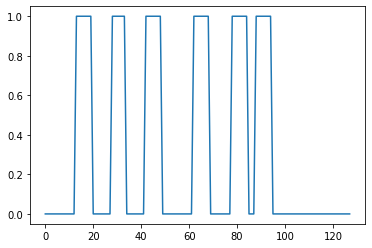

In [57]:
c=micro_numba(c0,r,ox,oy,oz,Nx,Ny,Nz)
plt.plot(c[:,0,0])
c_0=c

## Geomtry for spinodal decomposition

In [58]:
#initialize microstructure
c0=0.4  # initial concentration
c= micro_ch_pre(Nx,Ny,Nz,c0)
c0_save=c

In [59]:
ttime=0
#plot_micro_mayavi(c,ttime)
# nb: in interactive mode, close Mayavi plot before stop interaction

## plot using Pyvista

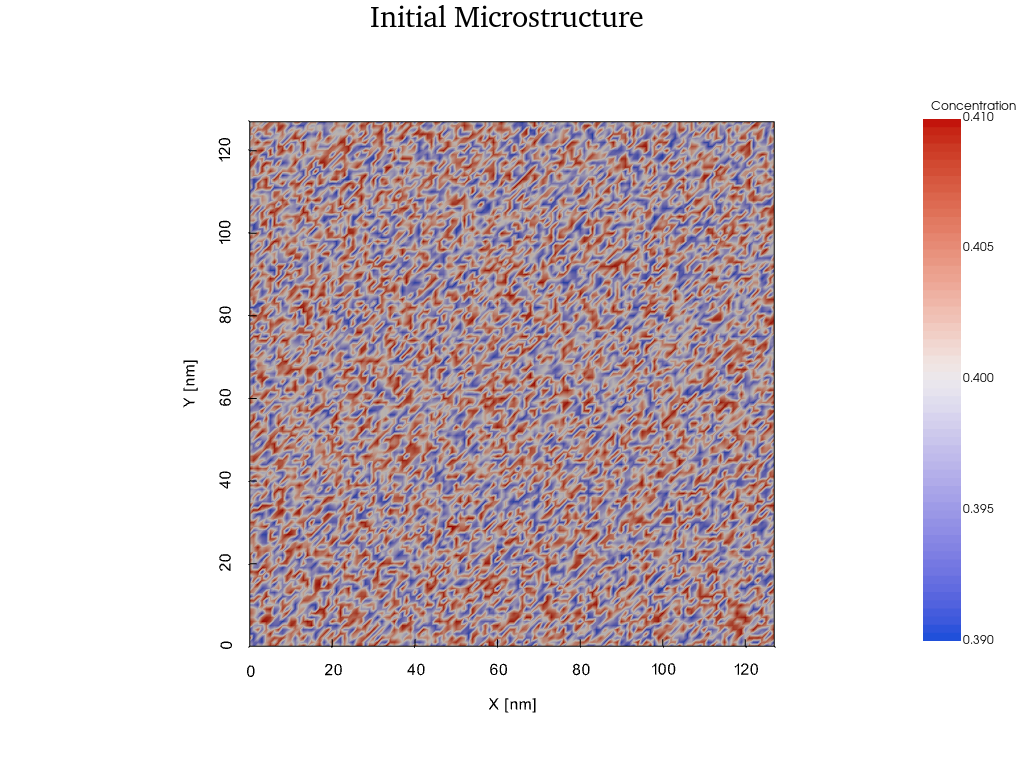

In [60]:
ttime=0
plot_micro(c,"2D",ttime)    

# Loop on time steps










simulation time : 222.229145526886 seconds ---


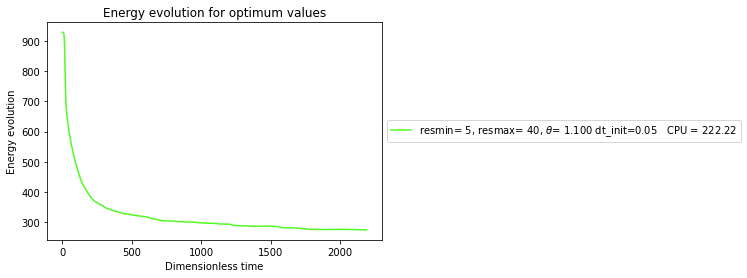

In [61]:
f = open("log.txt", "w") # to print residual evolution and follow iterations
f_dtime = open("dtime.txt", "w") # to print times steps during simulation
# loop to change time step (dtime) and compute associated energy dissipation for CH equation (at each time step) 
for index in range(len(array_resmin)):    # to make possible the change of  simulation parameters (resmin, resmax or theta) if needed,=> for index in      
                                         # range(len(array_resmax))
    # start simulation
    f.write('start simulation\n')
    
    t_start = time.time() 
    
    theta=array_theta[0]  
    resmin=array_resmin[index]  # the parameter to vary in sensitivity analysis
    resmax=array_resmax[0]
    dt_init=array_dt_init[0]

    c=c0_save  # take the same microstructure
    # time step and constant values
    ttime=0 # for each simulation 
    dtime=dt_init
    #------------------
    # time steps and print parameters
    Nt=10 # trial 
    nstep=1000 #int(round(Nt/dtime)) #
    endstep=nstep  # stop criteria
    nprint=100; # step to print
    # set fourier coefficient 
    # compute the spatial frequency term from fft
    k,k2,k4,x,y,z=prepar_fft(Nx,dx_s,Ny,dy_s,Nz,dz_s,opt="3d")


    
    array_time=np.zeros(nstep)  # to save time steps
    array_dtime=np.zeros(nstep) 

    array_c=np.zeros((nstep,Nx, Ny, Nz)) # to save concentration values for each time steps
    array_c_k=np.zeros((nstep,Nx, Ny, Nz)) # to save concentration value in Fourier space for each time step; needed to compute residual 
    array_df_dc_k=np.zeros((nstep,Nx, Ny, Nz))# to save energy derivative values in Fourier space, for each time step; needed to compute residual 
    array_df_dc=np.zeros((nstep,Nx, Ny, Nz))  # to save energy derivative values in real space, for each time step; needed to compute    residual 
    dfdc=np.zeros((Nx,Ny,Nz))

    array_energy=np.zeros(nstep)  # to save energy value at each time step  
    array_residus=np.zeros(nstep)  # to store residual and its associated terms 
    array_residus_fd=np.zeros(nstep) # computed by finite difference
    array_energy_deriv=np.zeros(nstep) 
    array_energy_deriv_fd=np.zeros(nstep)
    array_energy_potentiel_grad=np.zeros(nstep) 
    array_energy_potentiel_grad_fd=np.zeros(nstep) 
    array_residual_deriv=np.zeros(nstep) 

   
    
    residual_deriv=1  # default valuefor the stop criteria
    flag=0   # to stop simulation
    
    t_start = time.time() # to compute CPU for each simulation 
    #-------------------------------------------------
    for istep in range(nstep):
    #-------------------------------------------------
        f.write('istep '+ str(istep)+'\n')

        # stop criteria
        
        if (flag==1):
            print('stop criteria reached')
            break # break the for loop
        

        iter=1  # iterations made when res > resmax  (see adaptive time stepping lines below)
        while True:
                if iter >1:
                    f.write('istep '+ str(istep) + ' is redone : iteration n° ' + str(iter) +'\n')
                # compute free energy 
                dfdc=free_energ(c)
                    
                dfdck=fft_(dfdc) 
                ck=fft_(c)
  
                # Time integration
                numer=dtime*mobility*k2*dfdck
                denom = 1.0 + dtime*coefA*mobility*grad_coef*k4
                ck =(ck-numer)/denom

                c=np.real(ifft_(ck))   

                # for small deviations
                c[np.where(c >= 0.9999)]= 0.9999
                c[np.where(c <= 0.00001)]=0.00001  

                # store computed variables
                energy=calculate_energ(Nx,Ny,Nz,c,grad_coef)
                array_energy[istep]=energy
                array_df_dc[istep]=dfdc
                array_df_dc_k[istep]=dfdck
                array_c[istep]=c
                array_c_k[istep]=ck
                ttime = ttime + dtime  # ttime is the cumulative simulation time
                array_dtime[istep]=dtime # to store dtime values => plot evolution 
                array_time[istep]=ttime

                #-----------------------------------------------------------------------------------------------     
                # --------------------------adaptive time stepping ---------------------------------------------
                #-----------------------------------------------------------------------------------------------  
                if (istep==0):
                    break # break the while loop (nothing to do) 
                if (istep>0):
                    #RE,energy_deriv,potentiel_grad=compute_residual_fft(array_energy,array_dtime[istep-1], array_df_dc_k,array_c_k,istep,k, grad_coef) #  Fourier transform 
                    RE_fd,energy_deriv_fd,potentiel_grad_fd=compute_residual_fd(dtime,array_energy,array_df_dc,array_c, grad_coef,istep)
                    #array_residus[istep]=RE
                    #array_energy_deriv[istep]=energy_deriv
                    #array_energy_potentiel_grad[istep]=potentiel_grad
                    array_energy_deriv_fd[istep]=energy_deriv_fd
                    array_energy_potentiel_grad_fd[istep]=potentiel_grad_fd
                    array_residus_fd[istep]=RE_fd
                    RE=RE_fd 
                    potentiel_grad=potentiel_grad_fd
                    energy_deriv=energy_deriv_fd

                    # criteria based on derivative of the energy residual
                    residual_deriv=(array_residus[istep]-array_residus[istep-1])/array_dtime[istep]
                    array_residual_deriv[istep]=residual_deriv

                    # stop criteria ==> break the while loop ==> break the main loop

                    #print(residual_deriv_mean)
                    if (np.abs(np.sqrt(potentiel_grad_fd))<0.01) :  
                        print(istep,np.sqrt(potentiel_grad_fd))
                        flag=1
                        endstep=istep
                        break # break the while loop
                                        
                   
                   #RE,A,B=compute_residual_FD(array_energy,array_dtime[istep-1], array_df_dc,array_c,istep, grad_coef) # Finite difference

                    if (RE>resmax):
                        f.write('RE>resmax\n')
                        dtime=dtime/theta
                        f_dtime.write('iteration '+ str(iter)+'       ')
                        iter +=1
                        # compute energy derivative with respect to time
                        energy_deriv=(array_energy[istep]-array_energy[istep-1])/array_dtime[istep]


                        f.write ('Residual = '+ str('{0:.2f}'.format(RE)) + ','+ ' A= ' + str('{0:.2f}'.format(energy_deriv))+ ','+ ' B= '+str('{0:.2f}'.format(potentiel_grad))+ ',' + 'Energy=                         '+ str('{0:.2f}'.format(energy) )+'\n')
                        #f.write('restarting the actual istep '+ str(istep)+ '\n')
                        continue   # continue the while loop =>  restart the "for loop" actual step with a new dtime=> recompute c and RE
                
                    elif (RE<resmax) and (RE>resmin) :
                        f.write(' We get  (resmin<RE<resmax) ;  go to step '+str(istep+1)+'\n')
                        f.write ('Residual = '+ str('{0:.2f}'.format(RE)) + ','+ ' A= ' + str('{0:.2f}'.format(energy_deriv))+ ','+ ' B= '+str('{0:.2f}'.format(potentiel_grad))+ ',' + 'Energy=                         '+ str('{0:.2f}'.format(energy) )+'\n'+'\n')
        
                        break # break the while loop => go to next "for loop" iteration with a new dtime 

                    else: # (RE<resmin):
                        f.write(' We get  (RE < resmin);  go to step '+str(istep+1)+'\n')
                        dtime=dtime*theta 
                        f.write('Residual = '+ str('{0:.2f}'.format(RE)) + ','+ ' A= ' + str('{0:.2f}'.format(energy_deriv))+ ','+ ' B= '+str('{0:.2f}'.format(potentiel_grad))+ ',' + 'Energy=                         '+ str('{0:.2f}'.format(energy) )+'\n'+'\n')
                                 
                        break # break the while loop => go to next "for loop" iteration with a new dtime 
       
        #-----------------------------------------------------------------------------------------------   
        #-----------------------    end adaptive time stepping         ---------------------------------   
        #-----------------------------------------------------------------------------------------------   
        f_dtime.write('step '+ str(istep)+ '     dtime= ' +str('{0:.2f}'.format(dtime)) +'\n')
        #---------------------------------------------------------------------- -----------------------
        if (math.fmod(istep,nprint)==0) and (istep>0):  # to plot micrstructure evolution
            print('')
            # plot_micro(c,"3D",ttime)
            #plot_micro_mayavi(c,"3D,ttime)
            

            # plot actual microstructure
            """
            import matplotlib.pylab as plt1
            # 1D case
            rgb = np.random.rand(3,)
            if (istep==100):
                plt1.plot(c0_save[:, :, 0],  color ='r', label='initial concentration') # keep this indent
            plt1.plot(c[:, :, 0],  color =rgb, label='concentration at dimensionless time: '+str('{0:.2f}'.format(ttime)))
            plt1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt1.xlabel('x')
            plt1.ylabel('Concentration')
    plt1.plot(c0_save[:, :, 0],  color ='r', label='initial concentration') # keep this indent
    plt1.show()
    """
    
    #---------------------------------------------------------------------- -----------------------

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
    #-------------------------   Post processing   ------------------------------------
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------        
    # plot energy evolution during spinodal deomposition
    #---------------------------------------------------------------------------------- 
    energ = np.array(array_energy)
    array_time = np.array(array_time)
    rgb = np.random.rand(3,)
    plt.plot(array_time[:endstep],energ[:endstep],label = 'resmin= '+str(resmin)+ ", "+ 'resmax= '+str(resmax) + ", "+r'$\theta$= '+str('{0:.3f}'.format(array_theta[0]))+' dt_init='+str(dt_init) +"   CPU = "+ str('{0:.2f}'.format(time.time()-t_start)),color =rgb) 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Dimensionless time')
    plt.ylabel('Energy evolution')
    #plt.show() 
    name='Energy evolution ' + ".png"
    #plt.savefig(name)
    plt.title('Energy evolution for optimum values')
    #plt.show()
    #----------------------------------------------------------------------------------        
    #plot solution evolution in space for (y=x)
    #---------------------------------------------------------------------------------- 
    """
    #transform array_time (time steps sauvegarded) from list to array
    array_time=np.array(array_time)

    # return index of time of plot (here the end of simulation is chossen)
    time_plot=int(np.array(np.where(abs(array_time - ttime)<0.001)))
    print(time_plot)
    #solution at the choosen instant 
    sol=array_c[time_plot]
    # extract diagonal of the matrix "sol"
    x_y_solution=np.diag(sol)
    plt.xlabel('y=x')
    plt.ylabel('Concentration at the end of simulation')
    rgb = np.random.rand(3,)
    plt.plot(x_y_solution,label = "dt="+str(dtime),color =rgb)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    """
    #----------------------------------------------------------------------------------        
    # plot evolution of infinite norm versus time
    #---------------------------------------------------------------------------------
    """
    infinite_norm=[]
    array_c=np.array(array_c)
    for i in range (1,nstep):
        #compute infinite norm
        c_n=array_c[i]
        c_n__1=array_c[i-1]
        infinite_norm.append(np.max(c_n-c_n__1))
    infinite_norm=np.array( infinite_norm)  
    rgb = np.random.rand(3,)
    plt.plot(array_time[1:],infinite_norm,label = 'resmin= '+str(resmax)+ ", "+ 'resmax= '+str(resmin) )    
    plt.xlabel('t$^{n}$')
    plt.ylabel('||c$^{n}$ - c$^{n-1}$||$_{inf}$')
    plt.title('Infinite norm evolution during spinodal decompostion - Method 1 for time stepping')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    """    




print("simulation time : %s seconds ---" % (time.time() - t_start))
f.close()
f_dtime.close()

# Postprocess

## infinity norm

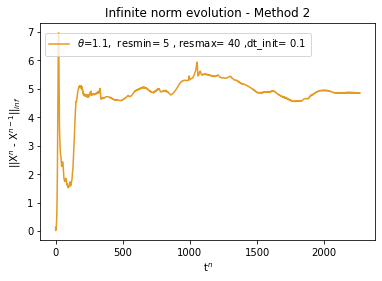

In [17]:
array_infinite_norm=[]
array_c=np.array(array_c)
for i in range (1,endstep):
    #compute infinite norm
    c_n=np.array(array_c[i])
    c_n__1=np.array(array_c[i-1])
    array_infinite_norm.append(infinite_norm(c_n-c_n__1))
array_infinite_norm=np.array(array_infinite_norm)  
rgb = np.random.rand(3,)
plt.plot(array_time[1:endstep],array_infinite_norm, label=r'$\theta$=' +str(theta) +  ", " + " resmin= "+str(resmin)+ " ," + " resmax= "+str(resmax)+" ," + "dt_init= " + str(dt_init) ,color      =rgb)  
plt.xlabel('t$^{n}$')
plt.ylabel('||X$^{n}$ - X$^{n-1}$||$_{inf}$')
plt.title('Infinite norm evolution - Method 2')
plt.legend(loc='center left', bbox_to_anchor=(0, 0.9))
plt.show()

## save energy 

In [65]:
array_time.shape

(1000,)

In [63]:
# save energy_vs_time in txt file : for comparative purposes
np.savetxt('energy_method_2.txt',energ[:endstep], fmt=' %.2f')
np.savetxt('time_method_2.txt',array_time[:endstep], fmt=' %.2f')

#energ_fd =np.loadtxt("energy_fd.txt",  delimiter=" ", unpack=False)

## dtime evolution

Text(0.5, 1.0, 'Time step evolution- Method 2')

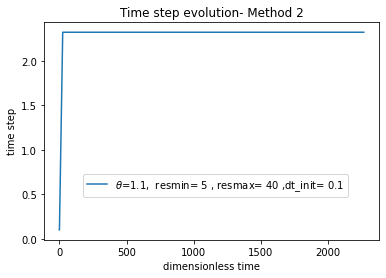

In [23]:
# plot dtime versus time evolution
plt.plot(array_time[:endstep],array_dtime[:endstep],label=r'$\theta$=' +str(theta) +  ", " + " resmin= "+str(resmin)+ " ," + " resmax= "+str(resmax)+" ," + "dt_init= " + str(dt_init))
plt.legend(loc='center left', bbox_to_anchor=(0.1, 0.25))
plt.xlabel('dimensionless time')
plt.ylabel('time step') 
plt.title('Time step evolution- Method 2')

## energy evolution

Text(0, 0.5, 'Energy evolution')

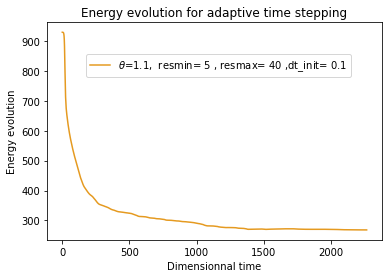

In [21]:
# Energy evolution
energ = np.array(array_energy[:endstep],)
plt.plot(array_time[:endstep],energ,label=r'$\theta$=' +str(theta) +  ", " + " resmin= "+str(resmin)+ " ," + " resmax= "+str(resmax)+" ," + "dt_init= " + str(dt_init),color =rgb)
plt.legend(loc='center left', bbox_to_anchor=(0.1, 0.8))
plt.title('Energy evolution for adaptive time stepping')
plt.xlabel('Dimensionnal time')
plt.ylabel('Energy evolution')


## Residual evolution

Text(0.5, 1.0, 'Energy residual evolution - Method 2')

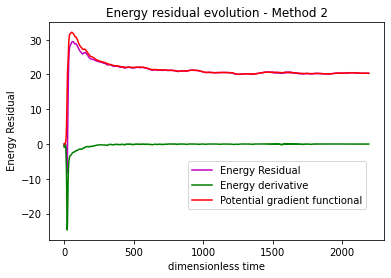

In [62]:
# plot dtime versus time evolution
#plt.plot(array_time,array_residus, label='Residus (FFT)',c='b')
plt.plot(array_time,array_residus_fd, label='Energy Residual',c='m')
#plt.plot(array_time,array_energy_deriv, label='Energy derivative',c='g')
plt.plot(array_time,array_energy_deriv_fd, label='Energy derivative',c='g')
#plt.plot(array_time,array_energy_potentiel_grad, label='Potentioel gradient functional',c='r')
plt.plot(array_time,array_energy_potentiel_grad_fd, label='Potential gradient functional',c='r')
plt.legend(loc='center left', bbox_to_anchor=(0.4, 0.25))
plt.xlabel('dimensionless time')
plt.ylabel(' Energy Residual') 
plt.title('Energy residual evolution - Method 2')

## plot actual microstructure

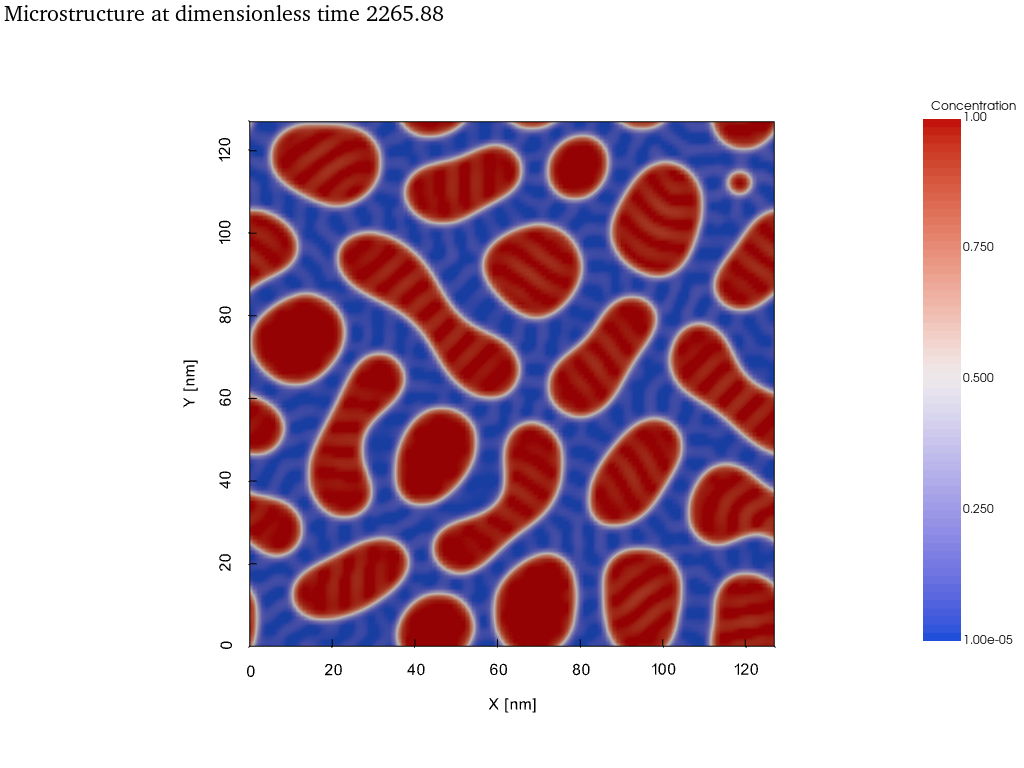

In [24]:
plot_micro(c,'2D',ttime)

## compare methods 1 and 2

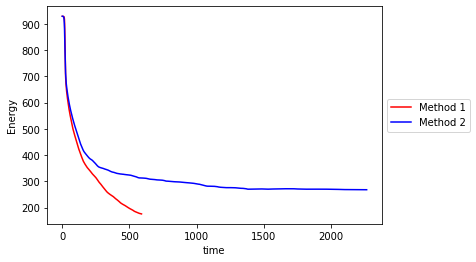

In [27]:
# save energy_vs_time in txt file : for comparative purposes
#np.savetxt('energy_method_2.txt',energ, fmt='%.2f')
#np.savetxt('time_method_2.txt',array_time, fmt=' %.2f')
energ_1 =np.loadtxt("energy_method_1.txt",   unpack=False)
energ_2 =np.loadtxt("energy_method_2.txt", unpack=False)
time_1 =np.loadtxt("time_method_1.txt", unpack=False)
time_2 =np.loadtxt("time_method_2.txt", unpack=False)
plt.plot(time_1,energ_1,label = 'Method 1', c='r') 
plt.plot(time_2,energ_2,label = 'Method 2',c='b')   
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Case of coarsening of precipitates study

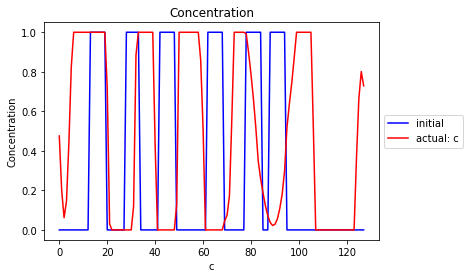

In [50]:
plt.plot(c0[:,0,0],label='initial',c='b')
plt.plot(c[:,0,0],label='actual: c',c='r')
#plt.plot(X_al_out[:,0,0],label='actual: Si in matrix',c='g')
#plt.plot(X_th_out[:,0,0],label='actual: Si in precipitates',c='m')
plt.xlabel("c")
plt.ylabel("Concentration")
plt.title('Concentration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

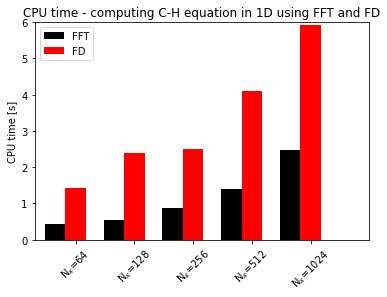

In [149]:
# plot histogram (to compare CPU time when using FFT or FD to compute CH equation in 1D)
#makes the data
fig = plt.figure()
ax = fig.add_subplot(111)

## the data
N = 5
fft = [0.42,0.53,0.87,1.39,2.48]
fd =   [1.43,2.38,2.51,4.1,5.93]



## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

rects1 = ax.bar(ind, fft, width,
                color='black',
                error_kw=dict(elinewidth=2,ecolor='red'))

rects2 = ax.bar(ind+width, fd, width,
                    color='red',
                    error_kw=dict(elinewidth=2,ecolor='black'))
# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,6)
ax.set_ylabel('CPU time [s]')
ax.set_title('CPU time - computing C-H equation in 1D using FFT and FD')
xTickMarks = ['N$_x$='+str(i) for i in [64,128,256,512,1024]]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('FFT', 'FD') )

plt.show()

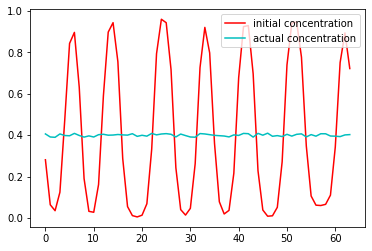

In [26]:
# 1D case
fig, ax = plt.subplots()
ax.plot(c[:, :, 0],  color ='r', label='initial concentration')
ax.plot(c0_save[:, :, 0],  color ='c', label='actual concentration')
leg = ax.legend()
#ax.xlabel('x')
#ax.ylabel('concentration')
#ax.title('initial and actual concentration after spinodal decomposition')

(400,)


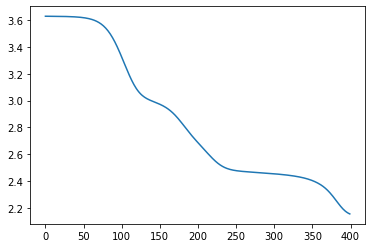

In [28]:
plt.plot(energ)
print(energ.shape)

In [71]:
# save energy_vs_time in txt file : for comparative purposes
n_lines=energ.shape[0]
energy_time_adap=np.ones((n_lines,2))
energy_time_adap[:,0]=timesteps
energy_time_adap[:,1]=energ

np.savetxt('energy_versus_time_adaptive.txt', energy_time_adap, fmt='%.2f')

In [ ]:
# plot microstructure

import sys

# grid2 : visualize c variable
grid = pv.UniformGrid()
grid.spacing=np.array([dx,dy,dz])*1E9
grid.dimensions = np.array(c.shape)
grid.point_arrays[r'Concentration'] = c.flatten(order="F")  # Flatten the array!

pv.set_plot_theme("document")           # = theme
cmap = plt.cm.get_cmap("coolwarm", 150) # = color map 

# contours for c variable = 0.001 and 0.99

contours = grid.contour(isosurfaces=2,rng=([0.01,0.99])) #[0.5, 1]
p = pv.Plotter()


p.camera_position = [0, -.75, -1]
p.add_mesh(grid,cmap=cmap, show_scalar_bar=True,opacity=1.,clim=[0.5,1])#)#,
p.add_mesh(contours,cmap=cmap, show_scalar_bar=True,color="black") #color="black",,clim=[1.,1.]
p.show_bounds(all_edges=True,xlabel="x [nm]",ylabel="y [nm]",zlabel="z [nm]")
sargs = dict(height=0.1, vertical=False, position_x=0.20, position_y=-0.01)

#p.show(cpos="xy")  # projection plotter.show
grid.plot(show_edges=True)
